G5: Jakober, Winkler, Matzinger, Salzmann

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [4]:
print(len(training_data), len(validation_data), len(test_data))

50000 10000 10000


### Fixed MLP with Increasing Training Dataset

Create a MLP with one hidden layer with 200 units for Fashion MNIST classification. Use ReLU activation.

Use a random fraction of the training set (split above) to perform the training. Always use the same validation set.

Use SGD and cross-entropy loss and suitable learning rate.

Start with a single small batch for training (batch size 8) and make sure that you can overfit, i.e. bring the training accuracy to 100%.

Then, gradually increase the training set. Let it grow until you obtain values for the training and the validation loss which no longer indicate overfitting. Use a fixed batch size (batchsize 32).

#### MLP Class

In [5]:
# define a method that provides an instance of an MLP which uses as a list of units per layer as input

def mlp(units = [28*28, 200, 10]):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers).
    """
    # YOUR CODE HERE #
    model = torch.nn.Sequential(
                torch.nn.Flatten(),
                torch.nn.Linear(units[0], units[1]),
                torch.nn.Sigmoid(),
                torch.nn.Linear(units[1], units[2])
    )
    return model
    

In [6]:
# create an instance and its summary

model = mlp()
from torchsummary import summary
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Linear: 1-2                            [-1, 200]                 157,000
├─Sigmoid: 1-3                           [-1, 200]                 --
├─Linear: 1-4                            [-1, 10]                  2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.61
Estimated Total Size (MB): 0.61


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Linear: 1-2                            [-1, 200]                 157,000
├─Sigmoid: 1-3                           [-1, 200]                 --
├─Linear: 1-4                            [-1, 10]                  2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.61
Estimated Total Size (MB): 0.61

#### Training Loop 

In [7]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data, l_norm=None, verbose=True):
    """
    Performs the training of a model with given learning rate (lr), 
    number of epochs (nepochs), batchsize (nbatch) and training and validation data.
    Suitable data loaders are instantiated for the training and validation datasets.
    Keep book about cost and accuracy (per epoch) for both training and validation set.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []


    # YOUR CODE HERE #
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    val_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

    for epoch in range(nepochs):
        running_loss_train = 0.0
        running_corr_train = 0
        running_size_train = 0

        model.train()
        for X_train, y_train in train_loader:
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            corr = (torch.argmax(y_pred, dim=1) == y_train).float().sum()

            if l_norm == 'L1':
                l1 = sum(p.norm(1) for p in model.parameters())
                loss += 0.001 * l1
            elif l_norm == 'L2':
                l2 = sum(p.norm(2) for p in model.parameters())
                loss += 0.001 * l2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss_train += loss.item()
            running_corr_train += corr.item()
            running_size_train += y_train.size(0)
        
        epoch_loss_train = running_loss_train / len(train_loader)
        epoch_acc_train = running_corr_train / running_size_train
        
        cost_hist.append(epoch_loss_train)
        acc_hist.append(epoch_acc_train)

        model.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            running_corr_val = 0
            running_size_val = 0

            for X_val, y_val in val_loader:
                y_pred = model(X_val)
                loss = criterion(y_pred, y_val)
                corr = (torch.argmax(y_pred, dim=1) == y_val).float().sum()

                running_loss_val += loss.item()
                running_corr_val += corr.item()
                running_size_val += y_val.size(0)

            epoch_loss_val = running_loss_val / len(val_loader)
            epoch_acc_val = running_corr_val / running_size_val

            cost_hist_test.append(epoch_loss_val)
            acc_hist_test.append(epoch_acc_val)

        if verbose and (epoch == 0 or (epoch+1) % 10 == 0):
            print(f'Epoch {epoch+1}\n Train Loss: {epoch_loss_train:.4f}, Train Accuracy: {epoch_acc_train:.4f}]\n Val Loss: {epoch_loss_val:.4f}, Val Accuracy: {epoch_acc_val:.4f}')
    
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

#### First Training

Run a first training with only one small training batch (e.g. with a single batch of 64 samples). 
The small training set can be created by using the functionality `torch.utils.data.random_split` already used above. As validation set use the `validation_data` created above.  

This training run can be used to test whether the model and training loop are properly implemented. Explain why and in what sense it can be used as test.

This is something you can always do when training a model.

32 49968


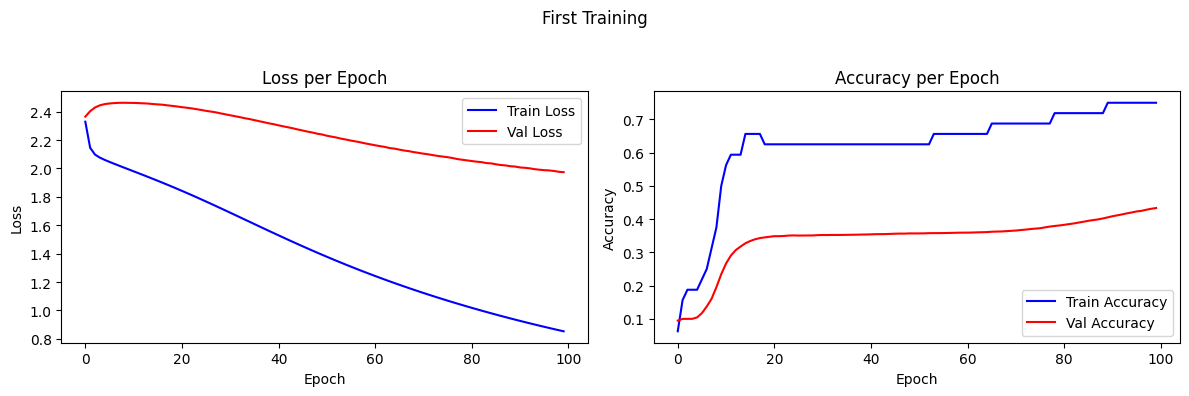

In [8]:
n_batch = 32
n_batches = 1
n_epochs = 100
lr = 0.1

trainsize = n_batches * n_batch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
print(len(trainset), len(rest))

model = mlp([28*28, 200, 10])
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, n_epochs, n_batch, trainset, validation_data, verbose=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), layout='tight')

ax[0].plot(range(n_epochs), cost_train, "b-", label='Train Loss')
ax[0].plot(range(n_epochs), cost_valid, "r-", label='Val Loss')
ax[0].set_title('Loss per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(n_epochs), acc_train, "b-", label='Train Accuracy')
ax[1].plot(range(n_epochs), acc_valid, "r-", label='Val Accuracy')
ax[1].set_title('Accuracy per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.suptitle(f'First Training')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

#### Evaluate Train and Validation Performance 

Now run several trainings with the same small model (one hidden layer) and explore for different number of training samples (different number of batches with 32 samples) used, how the train and validation performance evolve (cost and accuracy). Make sure that you train sufficiently long to obtain representative values for cost and accuracy with the given settings. Always use the same validation set (with 10'000 samples).

Create plots with training and validation performance vs number of training batches (one for cost and one for accuracy). Use the performance characteristics obtained at the end.

Discuss the whether there is a sufficient number of training samples for the given problem at hand. Specify a minimum number if applicable. Also consider whether you are in the underfitting regime.

Hint: Specify a list with the number of training batches you would like to perform trainings. Try to be economic with the resources used - try to keep the number of trainings limited.

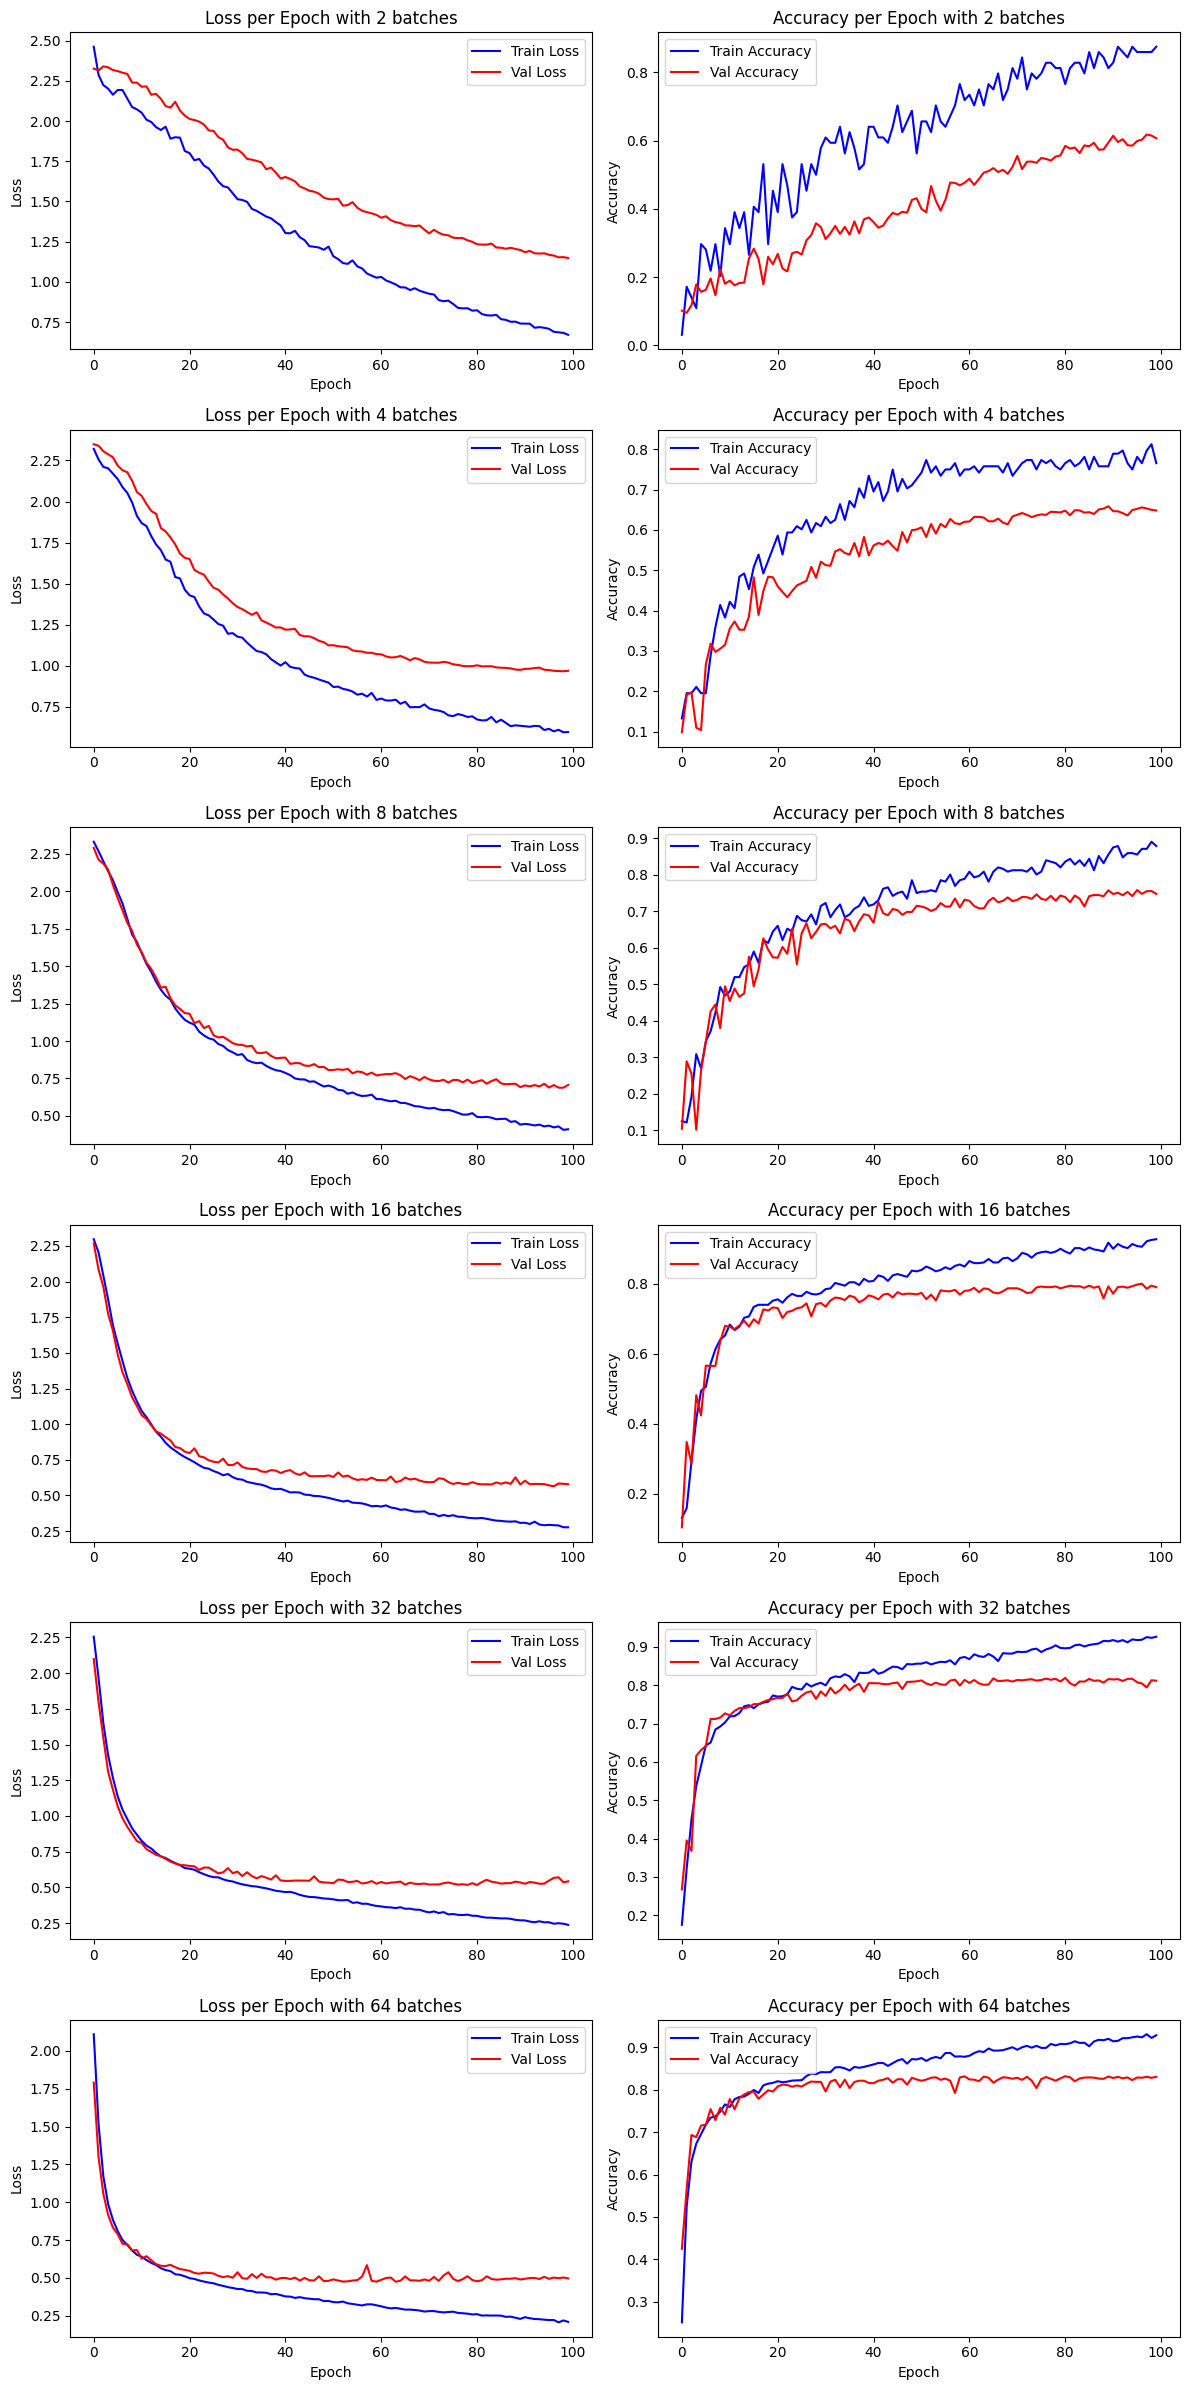

In [9]:
batch_size = 32
n_batches = [2, 4, 8, 16, 32, 64]
n_epochs = 100
lr = 0.1

fig, ax = plt.subplots(len(n_batches), 2, figsize=(12, 4 * len(n_batches)), layout='tight')

for i, batch in enumerate(n_batches):

    trainsize = batch * batch_size
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])

    model = mlp([28*28, 200, 10])
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, n_epochs, batch_size, trainset, validation_data, verbose=False)
    
    ax[i, 0].plot(range(n_epochs), cost_train, "b-", label='Train Loss')
    ax[i, 0].plot(range(n_epochs), cost_valid, "r-", label='Val Loss')
    ax[i, 0].set_title(f'Loss per Epoch with {batch} batches')
    ax[i, 0].set_xlabel('Epoch')
    ax[i, 0].set_ylabel('Loss')
    ax[i, 0].legend()

    ax[i, 1].plot(range(n_epochs), acc_train, "b-", label='Train Accuracy')
    ax[i, 1].plot(range(n_epochs), acc_valid, "r-", label='Val Accuracy')
    ax[i, 1].set_title(f'Accuracy per Epoch with {batch} batches')
    ax[i, 1].set_xlabel('Epoch')
    ax[i, 1].set_ylabel('Accuracy')
    ax[i, 1].legend()

plt.show()

#### Comments: 
The model underfits the data when only two and four batches are used.\
When eight or more batches are used, the model starts to overfit the data, which can be seen in both the loss and the accuracy.\
Initially, both train and val loss and train and val acc move together, but with more epochs the two losses and accuracies diverge.\
Another finding is that the model learns faster with more batches, i.e. it needs fewer epochs to achieve lower loss and higher accuracy.

### Evaluate Different Model Complexities

Use the same functionality implemented above (create MLP model, train and evaluate model) to evaluate different model complexities: Number of layers and number of units per layer.

Start with the small model used in Exercise 2. Then gradually increase the model complexity. Do this along two dimensions:
* a single hidden layer, but increasing the number of units.
* a fixed number of units per (hidden) layer, but increase the number of layers.
Make sure that you reach the overfitting regime (in either case).

Always use the full training set with 50'000 samples.

Again make sure that you train sufficiently long so that the obtained train and validation performance measures (cost, accuracy) are representative.

Create plots with training and validation performance (cost, accuracy) vs model complexity - one plot with number of units for the single hidden layer case, and one for varying number of layers. 

Again use the performance characteristics obtained at the end. 

Finally, discuss your findings.

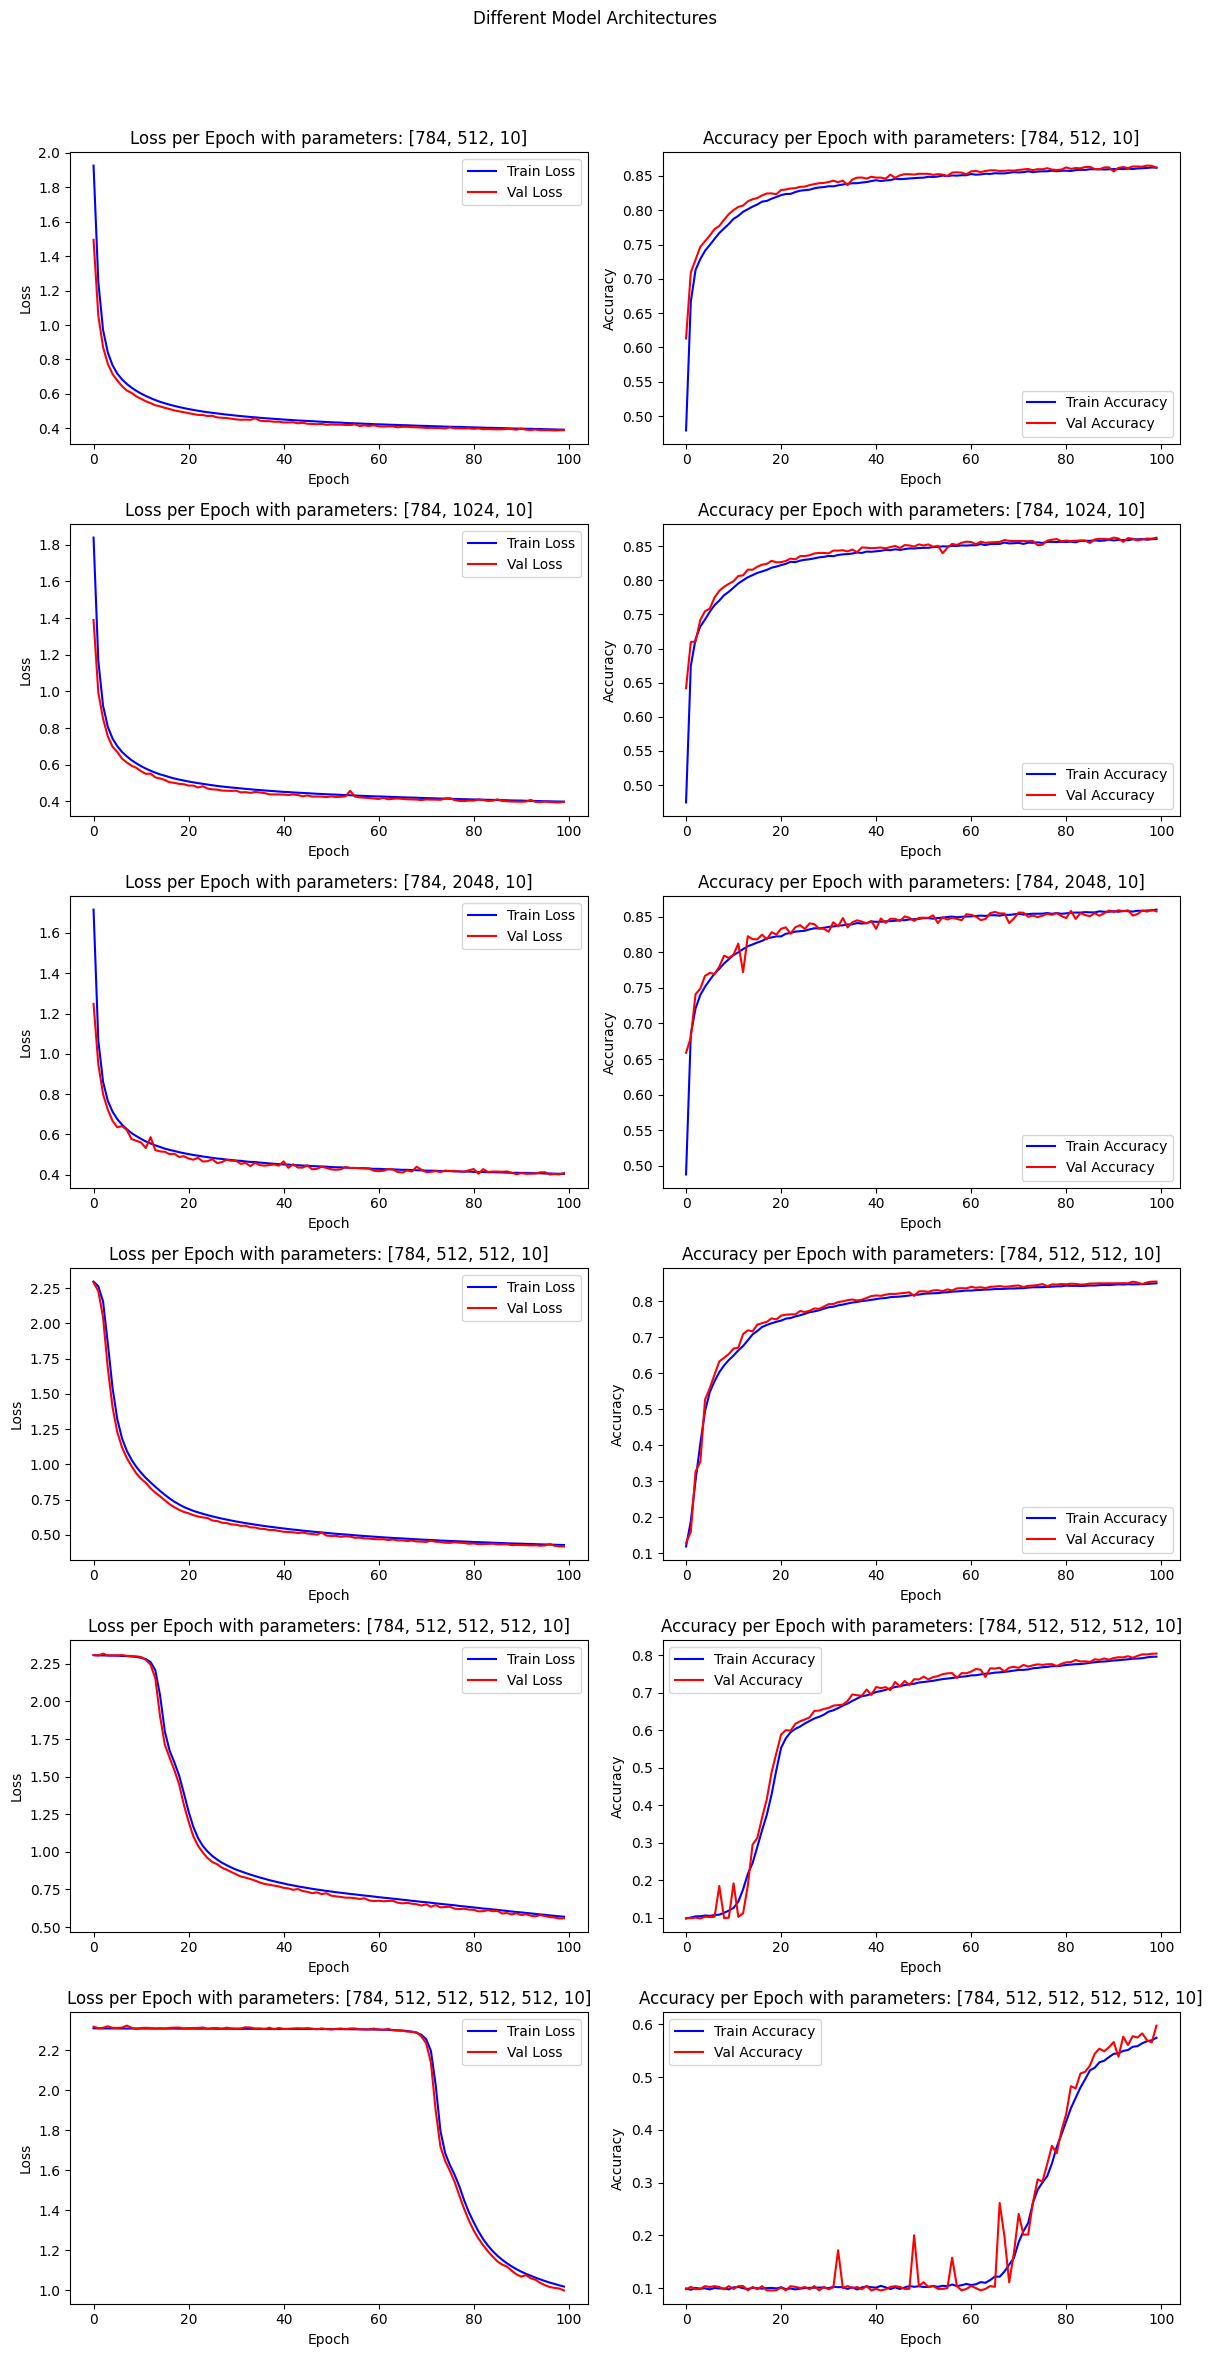

In [18]:
# YOUR CODE HERE #
# several iterations with the code snippets of the form:

def mlp(units=[28*28, 200, 10]):
    layers = [torch.nn.Flatten()]
    
    for i in range(len(units) - 1):
        layers.append(torch.nn.Linear(units[i], units[i+1]))
        if i < len(units) - 2:
            layers.append(torch.nn.Sigmoid())
    
    model = torch.nn.Sequential(*layers)
    return model

n_batch = 64
n_epochs = 100
lr = 0.01

params = [
    [28*28, 512, 10],
    [28*28, 1024, 10],
    [28*28, 2048, 10],
    [28*28, 512, 512, 10],
    [28*28, 512, 512, 512, 10],
    [28*28, 512, 512, 512, 512, 10]
]

fig, ax = plt.subplots(len(params), 2, figsize=(12, 4 * len(params)), layout='tight')

for i, units in enumerate(params):
    model = mlp(units)
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, n_epochs, n_batch, training_data, validation_data, verbose=False)

    ax[i, 0].plot(range(n_epochs), cost_train, "b-", label='Train Loss')
    ax[i, 0].plot(range(n_epochs), cost_valid, "r-", label='Val Loss')
    ax[i, 0].set_title(f'Loss per Epoch with parameters: {units}')
    ax[i, 0].set_xlabel('Epoch')
    ax[i, 0].set_ylabel('Loss')
    ax[i, 0].legend()

    ax[i, 1].plot(range(n_epochs), acc_train, "b-", label='Train Accuracy')
    ax[i, 1].plot(range(n_epochs), acc_valid, "r-", label='Val Accuracy')
    ax[i, 1].set_title(f'Accuracy per Epoch with parameters: {units}')
    ax[i, 1].set_xlabel('Epoch')
    ax[i, 1].set_ylabel('Accuracy')
    ax[i, 1].legend()

    plt.suptitle(f'Different Model Architectures')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

#### Comments:
The deeper and more complex the model, the more epochs it takes to converge.\
Also, the more complex the model, the more unstable the performance becomes, which is reflected in the validation accuracy.

### Add Regularisation

Finally, add regularisation - dropout or L1/L2-regularisation. 

To this end, you need to implement new functionality to instantiate the model.

Start with one of the overfitting cases of Exercise 3 and try to improve the validation performance by adding regularisation. You can use either dropout or L1/L2-regularisation.


In [12]:
# define a method that provides an instance of an MLP incl regularisation which uses as a list of units per layer as input 

def mlp_dropout(units = [28*28, 200, 10], p_in = 0.2, p_hidden=0.5):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers) and dropout 
    regularisation. Dropout rate for all layers the same except for the first (p_in). For the output layer 
    no dropout applied. 
    """

    # YOUR CODE HERE #
    model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Dropout(p_in),
        torch.nn.Linear(units[0], units[1]),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(p_hidden),
        torch.nn.Linear(units[1], units[2])
    )

    return model  
    

In [13]:
model = mlp_dropout([28*28,200,10])
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Dropout: 1-2                           [-1, 784]                 --
├─Linear: 1-3                            [-1, 200]                 157,000
├─Sigmoid: 1-4                           [-1, 200]                 --
├─Dropout: 1-5                           [-1, 200]                 --
├─Linear: 1-6                            [-1, 10]                  2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.61
Estimated Total Size (MB): 0.61


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Dropout: 1-2                           [-1, 784]                 --
├─Linear: 1-3                            [-1, 200]                 157,000
├─Sigmoid: 1-4                           [-1, 200]                 --
├─Dropout: 1-5                           [-1, 200]                 --
├─Linear: 1-6                            [-1, 10]                  2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.61
Estimated Total Size (MB): 0.61

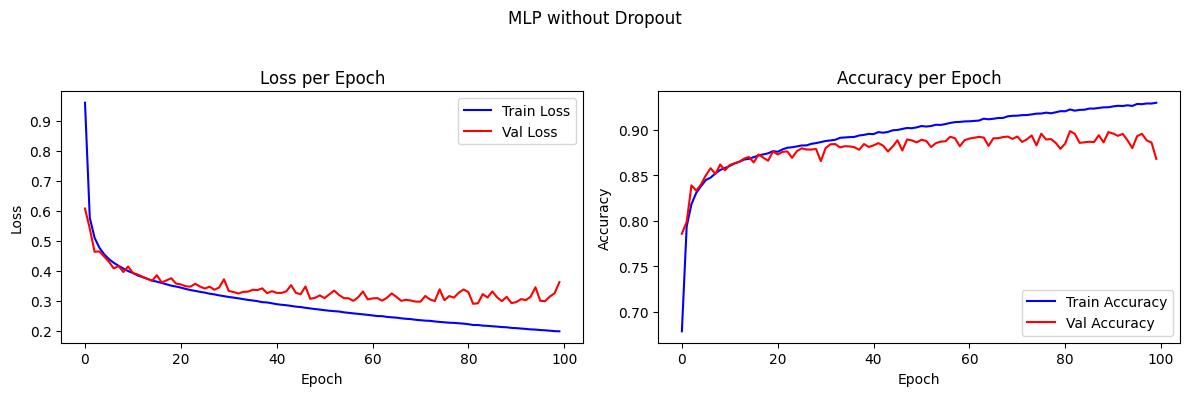

In [14]:
nbatches = 64
n_epochs = 100
lr = 0.1

model = mlp([28*28, 200, 10])
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, n_epochs, nbatches, training_data, validation_data, verbose=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), layout='tight')

ax[0].plot(range(n_epochs), cost_train, "b-", label='Train Loss')
ax[0].plot(range(n_epochs), cost_valid, "r-", label='Val Loss')
ax[0].set_title('Loss per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(n_epochs), acc_train, "b-", label='Train Accuracy')
ax[1].plot(range(n_epochs), acc_valid, "r-", label='Val Accuracy')
ax[1].set_title('Accuracy per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.suptitle(f'MLP without Dropout')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

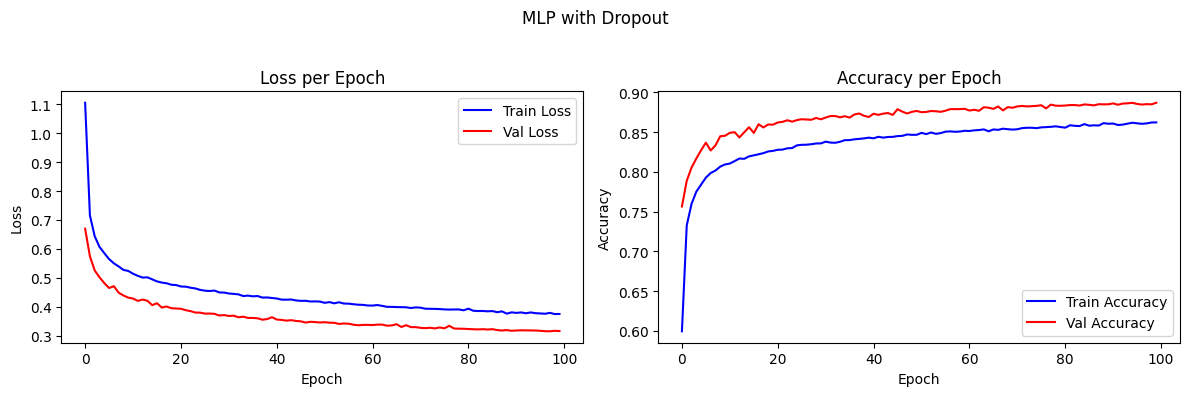

In [15]:
nbatches = 64
n_epochs = 100
lr = 0.1

model = mlp_dropout([28*28, 200, 10])
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, n_epochs, nbatches, training_data, validation_data, verbose=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), layout='tight')

ax[0].plot(range(n_epochs), cost_train, "b-", label='Train Loss')
ax[0].plot(range(n_epochs), cost_valid, "r-", label='Val Loss')
ax[0].set_title('Loss per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(n_epochs), acc_train, "b-", label='Train Accuracy')
ax[1].plot(range(n_epochs), acc_valid, "r-", label='Val Accuracy')
ax[1].set_title('Accuracy per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.suptitle(f'MLP with Dropout')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

#### Playing with different complexities and regularisation

Now play with different complexities and regularisation. 
Start with one of the overfitting cases identified in the previous exercise.
By adding regularisation, you should be able to make it non-overfitting, i.e. generalising better.
Note that for a given complexity, adding regularisation reduces the model capacity. This may need to be compensated by increasing the complexity of the model. 

Use again cost and accuracy for train and validation set to evaluate the results.

Finally, estimate the bias error and the generalisation error. 

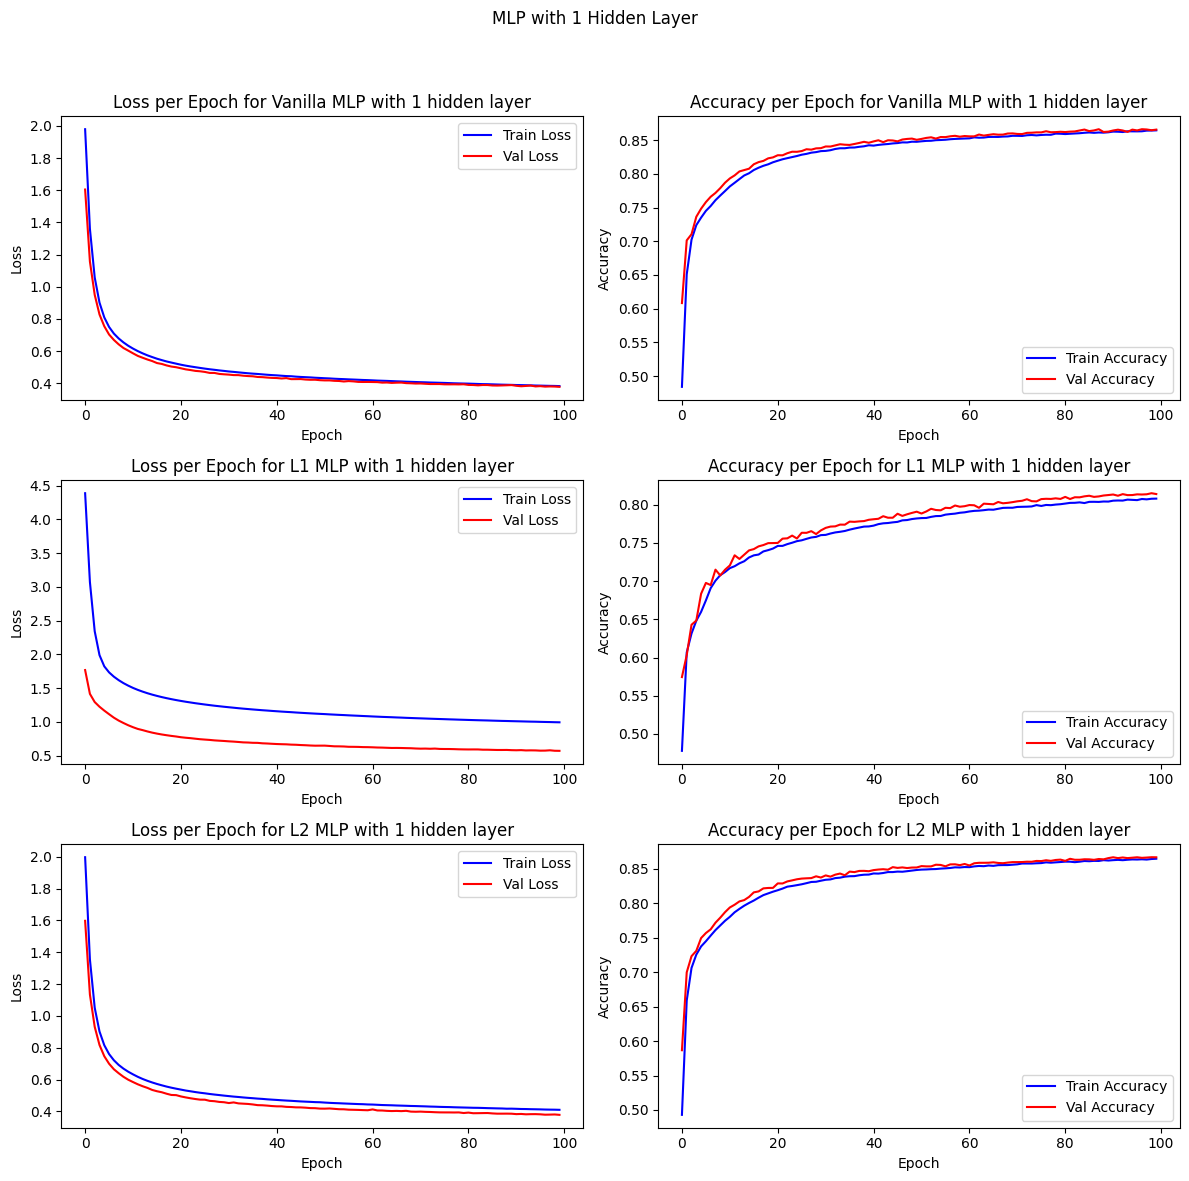

Bias Error: 0.4106
Generalization Error: -0.0315


In [16]:
nbatches = 64
n_epochs = 100
lr = 0.01

regularizations = ['Vanilla', 'L1', 'L2']

fig, ax = plt.subplots(len(regularizations), 2, figsize=(12, 4 * len(regularizations)), layout='tight')

for i, l_norm in enumerate(regularizations):
    model = mlp([28*28, 200, 10])
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, n_epochs, nbatches, training_data, validation_data, l_norm=l_norm, verbose=False)

    ax[i, 0].plot(range(n_epochs), cost_train, "b-", label='Train Loss')
    ax[i, 0].plot(range(n_epochs), cost_valid, "r-", label='Val Loss')
    ax[i, 0].set_title(f'Loss per Epoch for {l_norm} MLP with 1 hidden layer')
    ax[i, 0].set_xlabel('Epoch')
    ax[i, 0].set_ylabel('Loss')
    ax[i, 0].legend()

    ax[i, 1].plot(range(n_epochs), acc_train, "b-", label='Train Accuracy')
    ax[i, 1].plot(range(n_epochs), acc_valid, "r-", label='Val Accuracy')
    ax[i, 1].set_title(f'Accuracy per Epoch for {l_norm} MLP with 1 hidden layer')
    ax[i, 1].set_xlabel('Epoch')
    ax[i, 1].set_ylabel('Accuracy')
    ax[i, 1].legend()

    plt.suptitle(f'MLP with 1 Hidden Layer')
    plt.tight_layout(rect=[0, 0, 1, 0.95])    

plt.show()

print(f'Bias Error: {cost_train[-1]:.4f}')
print(f'Generalization Error: {cost_valid[-1] - cost_train[-1]:.4f}')

#### Comments

The use of the L1 norm gives less stable results in terms of validation accuracy as well as a lower accuracy score in general.\
The vanilla and L2 norm models have similar performance with no visible overfitting and an accuracy score of ~ 0.85.

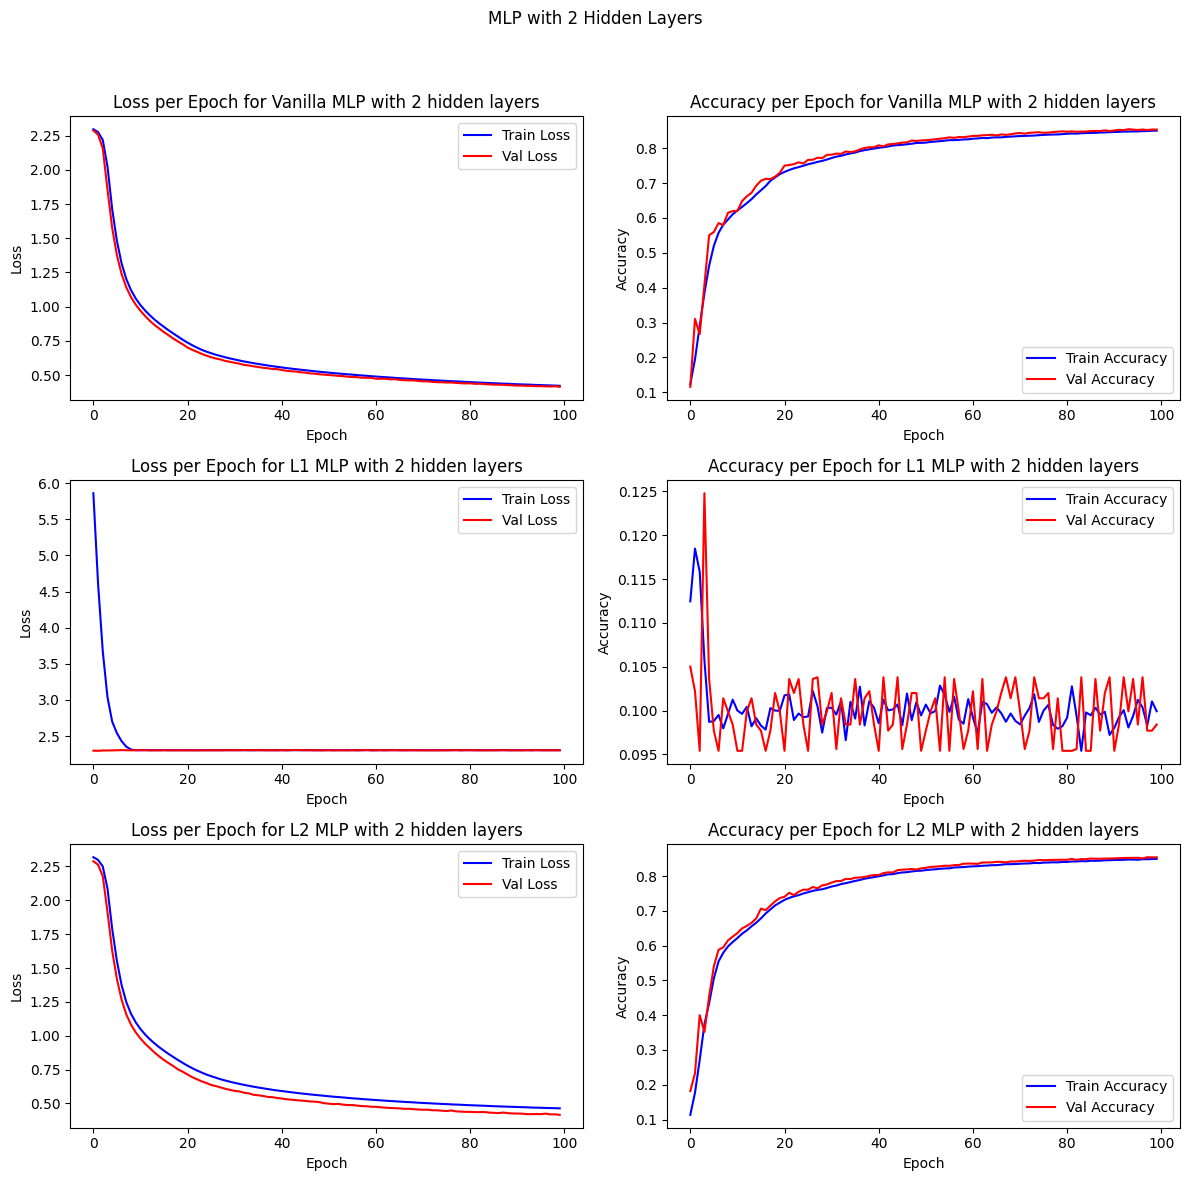

Bias Error: 0.4632
Generalization Error: -0.0479


In [17]:
nbatches = 64
n_epochs = 100
lr = 0.01

regularizations = ['Vanilla', 'L1', 'L2']

fig, ax = plt.subplots(len(regularizations), 2, figsize=(12, 4 * len(regularizations)), layout='tight')

for i, l_norm in enumerate(regularizations):
    model = mlp([28*28, 200, 200, 10])
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, n_epochs, nbatches, training_data, validation_data, l_norm=l_norm, verbose=False)

    ax[i, 0].plot(range(n_epochs), cost_train, "b-", label='Train Loss')
    ax[i, 0].plot(range(n_epochs), cost_valid, "r-", label='Val Loss')
    ax[i, 0].set_title(f'Loss per Epoch for {l_norm} MLP with 2 hidden layers')
    ax[i, 0].set_xlabel('Epoch')
    ax[i, 0].set_ylabel('Loss')
    ax[i, 0].legend()

    ax[i, 1].plot(range(n_epochs), acc_train, "b-", label='Train Accuracy')
    ax[i, 1].plot(range(n_epochs), acc_valid, "r-", label='Val Accuracy')
    ax[i, 1].set_title(f'Accuracy per Epoch for {l_norm} MLP with 2 hidden layers')
    ax[i, 1].set_xlabel('Epoch')
    ax[i, 1].set_ylabel('Accuracy')
    ax[i, 1].legend()

    plt.suptitle(f'MLP with 2 Hidden Layers')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

print(f'Bias Error: {cost_train[-1]:.4f}')
print(f'Generalization Error: {cost_valid[-1] - cost_train[-1]:.4f}')

#### Comments

Using two hidden layers instead of one not only leads to worse results for the vanilla and L2 models, but the L1 model is unable to learn meaningful patterns from the data.